# t-SNE Cell Line Clustering with Phosphorylation Data
I'll use t-SNE to get an overview of cell line clustering before and after different normalization procedures for hte CST data. 

## Imports and Function Definitions

In [67]:
import numpy as np
from matplotlib import pyplot as plt
from tsne import bh_sne
from copy import deepcopy
from clustergrammer import Network 

In [60]:
def make_cl_tsne_hist_plex(mat, cmap_left=None, cmap_right=None):
    # the matrix needs to be transposed in order to cluster the numbers
    x_data = mat.transpose()

    # convert image data to float64 matrix. float64 is need for bh_sne
    x_data = np.asarray(x_data).astype('float64')

    # perform t-SNE embedding, lowered perplexity
    vis_data = bh_sne(x_data, perplexity=5)

    # plot the result
    vis_x = vis_data[:, 0]
    vis_y = vis_data[:, 1]

    fig, axarr = plt.subplots(ncols=2, figsize=(10,5))
    
    marker_size = 150
    
    if cmap_left == None:
        axarr[0].scatter(vis_x, vis_y, s=marker_size)
    else:
        axarr[0].scatter(vis_x, vis_y, c=cmap_left, cmap=plt.cm.get_cmap('prism',len(cmap_left)), s=marker_size)
    
    if cmap_right == None:
        axarr[1].scatter(vis_x, vis_y, marker_size)
    else:
        axarr[1].scatter(vis_x, vis_y, c=cmap_right, cmap=plt.cm.get_cmap('jet',len(cmap_right)), s=marker_size) 

    plt.show()

In [56]:
def make_simple_cl_names(tuple_cols):
    cl_names = []
    for inst_tuple in tuple_cols:
        cl_names.append(inst_tuple[0])
    return cl_names

# load cell line information 
cl_info = net.load_json_to_dict('../cell_line_info/cell_line_info_dict.json')

def make_hist_cmap(cl_names):
    hist_cmap = [] 
    for inst_cl in cl_names:
        inst_hist = cl_info[inst_cl]['Histology']
        if inst_hist == 'NSCLC':
            hist_cmap.append(0)
        else:
            hist_cmap.append(1)
    return hist_cmap

def make_plex_cmap(cl_names):
    plex_cmap = []
    for inst_cl in cl_names:
        inst_plex = cl_info[inst_cl]['Plex']
        plex_cmap.append(inst_plex)
    return plex_cmap


# Clustering Original Data (including missing values)
First, I will cluster the cell lines (using t-SNE) based on the original phosphorylation data - including phosphorylation with missing values. Since cell lines from the same plex share the same missing data we would expect that including missing data (which is ultimately set to zeros) will cause the cell lines to artificially cluster based on their plexes. 

shape of matrix: (5798, 45)


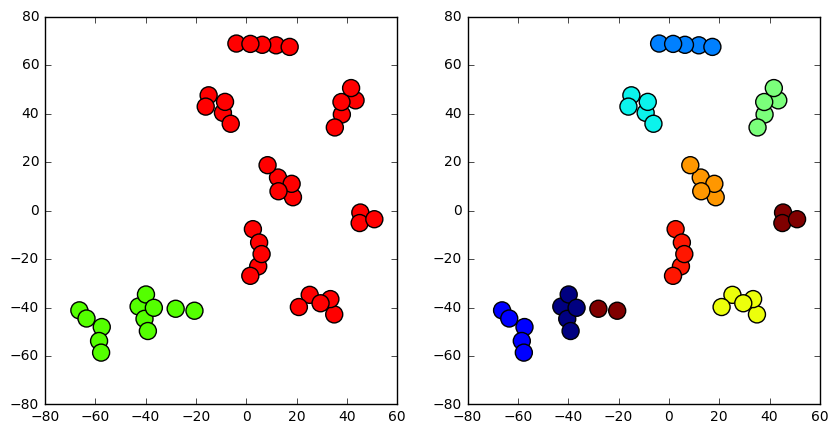

In [80]:
filename = '../lung_cellline_3_1_16/lung_cellline_phospho/' + \
'lung_cellline_TMT_phospho_combined_ratios.tsv'

# get matrix of data for tsne 
net = deepcopy(Network())
net.load_file(filename)
net.swap_nan_for_zero()
inst_df = net.dat_to_df()
mat = inst_df['mat'].values

# make colormaps based on histology and plexes
tuple_cols = df.columns.tolist()
cl_names = make_simple_cl_names(tuple_cols)
hist_cmap = make_hist_cmap(cl_names)
plex_cmap = make_plex_cmap(cl_names)

print('shape of matrix: '+ str(mat.shape))
make_cl_tsne_hist_plex(mat, hist_cmap, plex_cmap)

### Conclusions: Cell lines cluster based on Histology and Plexes
The left tsne plot shows cell lines colored based on histology, SCLC is green and NSCLC is red. The cell cell lines appear to largely cluster based on shared histology. The right tsne plot shows cell lines colored based on their plex - there are 5 cell lines per plex. The cell lines cluster almost exclusively into groups that belong to the same plex. 

From these figures we can see that two plexes are composed of entirely SCLC cell lines. We can also see that there is a large batch effect that needs to be corrected. 

We will try the following procedures individually and in combination and check their effect on cell line clustering
* Normalize the cell line distributions so that they are more similar (e.g. quantile normalization)
* Z-score the PTM distributions to highlight differences between the cell lines
* Filter out PTMs with missing data

# Clustering with Column QN and Row Z-score
Now we will try clustering the cell lines after first quantile normalization of cell line distributions and second z-score of PTM rows. 

shape of matrix: (5798, 45)


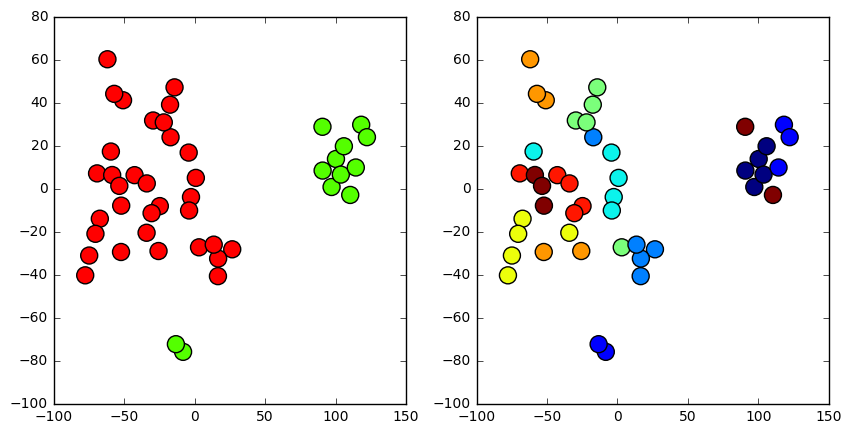

In [79]:
filename = '../lung_cellline_3_1_16/lung_cellline_phospho/' + \
'lung_cellline_TMT_phospho_combined_ratios.tsv'

net = deepcopy(Network())
net.load_file(filename)

# column quantile normalization to remove systematic differences in cell lines
net.normalize(axis='col', norm_type='qn')
# row Z-score normalization to highlight relative differences in PTM levels acrdoss cell lines
net.normalize(axis='row', norm_type='zscore')

net.swap_nan_for_zero()
inst_df = net.dat_to_df()
mat = inst_df['mat'].values

print('shape of matrix: '+ str(mat.shape))
make_cl_tsne_hist_plex(mat, hist_cmap, plex_cmap)

### Conclusions: Histology clustering is improved and plexes appear slightly more mixed
On the left we can see a distinct clustering of the cell lines based on their histology, with only two SCLC cell lines not clustering with the others. On the right we can see that the plexes in both SCLC and NSCLC are clustered more closely to eachother and appear more mixed together than in the original plot with no normalization. 

Keep in mind that PTMs with missing data have not been filtered out so we expect to still see some plex clustering. 

In [76]:
print(mat.shape)

(5798, 45)


# t-SNE Clustering with no missing data
Plexes have common missing data, which is why clustering the cell lines using phosphorylation data that has missing data will result in cell lines that cluster based on their plex. We can try clustering the cell lines using only the phosphorylations that have been measured in all cell lines to see if we still see the same pattern of cell line clustering. 